Note : Please use **PyTorch 2.0 Python 3.10 GPU kernel on g4dn.xlarge** for this notebook

# What's the use case?
In this lab we will generate synthetic satellite images. These images can be used for research or as input data for building your computer vision models.

# Stable Diffusion

## Why fine tune stable diffusion?

Although Stable diffusion is great at generating images, the quality of images that specialise in a particular are may not be great. For example, in this notebook we aim to generate satellite images. However, the default satellite images that are generated do show some of the features (such as highways) very well. To improve the quality of satellite images with highways, we fine-tune stable diffusion using real satellite images.

## How do we fine-tune

To fine-tune stable diffusion we use a method called DreamBooth which is described [here](https://dreambooth.github.io/). Here's a short description of dreambooth from the paper
> Our method takes as input a few images (typically 3-5 images suffice, based on our experiments) of a subject (e.g., a specific dog) and the corresponding class name (e.g. "dog"), and returns a fine-tuned/"personalized'' text-to-image model that encodes a unique identifier that refers to the subject. Then, at inference, we can implant the unique identifier in different sentences to synthesize the subjects in difference contexts.

**Lets Get started!**
The first step is to get a feel of the hardware. A reminder though, please make sure you have the right kernel and notebook size as specified at the top!



In [1]:
!nvidia-smi

Tue Jun 27 02:23:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   60C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Next, we install a few libraries that the notebook needs.

In [4]:
!pip install transformers accelerate>=0.16.0 ftfy tensorboard Jinja2 huggingface_hub wandb kaggle git+https://github.com/huggingface/diffusers

  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-f7uo9502


### Setup Kaggle
This notebook, uses real satellite images from Kaggle for fine-tuning. If you don't have Kaggle credentials, then follow the instructions [here](https://github.com/Kaggle/kaggle-api#api-credentials) to get your Kaggle credentials. You will need the credentials to proceed.

In [5]:
#!mkdir /root/.kaggle.

In [6]:
# %%writefile /root/.kaggle/kaggle.json
# {"username":"<get this from kaggle>","key":"<get this from kaggle>"}

Download the dataset from kaggle

In [7]:
# !kaggle datasets download apollo2506/eurosat-dataset

### Dataset
For this tutorial, we will use the EuroSAT dataset, which is a land use classification dataset consisting of Sentinel 2 Satellite images. We will use the `Highway` class as the type of satellite image that we would like to generate. The `Forest` and `Industrial` classes serve as the *class* that we want the model to separate the `Highway` *instance*. Note, for the purposes of this exercise, we will display all images resized to 64,64 to match the EuroSAT dataset image size.



In [8]:
!mkdir -p EuroSAT/Highway
!unzip -q eurosat-dataset.zip "EuroSAT/Highway/*" -d ""

In [9]:
!mkdir -p EuroSAT/base/Forest
!unzip -q eurosat-dataset.zip "EuroSAT/Forest/*" -d "base"

In [10]:
!mkdir -p EuroSAT/base/Industrial
!unzip -q eurosat-dataset.zip "EuroSAT/Industrial/*" -d "base"

## View Dataset
Let's view the `Highway` class of the EuroSAT dataset

In [4]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

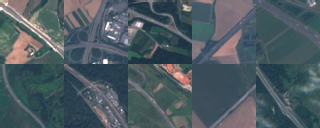

In [12]:
actual_img = [Image.open("EuroSAT/Highway/Highway_{}.jpg".format(str(i))) for i in range(1,11)]
image_grid([x.resize((64,64)) for x in actual_img], 2,5)

Let's view the `Forest` and `Industrial` classes:

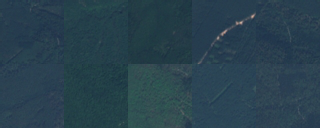

In [13]:
actual_img = [Image.open("base/EuroSAT/Forest/Forest_{}.jpg".format(str(i))) for i in range(1,11)]
image_grid([x.resize((64,64)) for x in actual_img], 2,5)

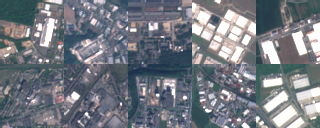

In [14]:
actual_img = [Image.open("base/EuroSAT/Industrial/Industrial_{}.jpg".format(str(i))) for i in range(1,11)]
image_grid([x.resize((64,64)) for x in actual_img], 2,5)

In [15]:
import shutil, os
forest_files = os.listdir("base/EuroSAT/Forest")
industrial_files = os.listdir("base/EuroSAT/Industrial")

In [16]:
!mkdir -p "base/class"

Some preparatory stuff. Copy the files to a location that we can use during fine-tuning

In [17]:
for filename in forest_files:
    shutil.copyfile(
        os.path.join("base/EuroSAT/Forest",filename),
        os.path.join("base/class",filename)
    )
for filename in industrial_files:
    shutil.copyfile(
        os.path.join("base/EuroSAT/Industrial",filename),
        os.path.join("base/class",filename)
    )

## Images generated by Stable Diffusion
Before we start fine-tuning, lets have a look at the default images generated by Stable Diffusion. We use Stable Diffusion (1.5) to generate satellite images of the `Highway` class. 

We leverate the [Diffusers](https://huggingface.co/docs/diffusers/index) library from Huggingface for the generation.

In [18]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.18.0.dev0",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [19]:
img_list = pipe(["Sentinel 2 satellite image of a highway"]*10, num_inference_steps=25).images

100%|██████████| 25/25 [00:30<00:00,  1.21s/it]


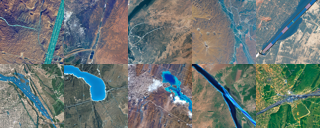

In [20]:
image_grid([x.resize((64,64)) for x in img_list], 2,5)

In [33]:
import gc
from numba import cuda
del(pipe)
gc.collect()
torch.cuda.empty_cache()

# device = cuda.get_current_device()
# device.reset()

## Actual highway class images from EuroSAT 

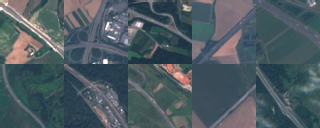

In [34]:
actual_img = [Image.open("EuroSAT/Highway/Highway_{}.jpg".format(str(i))) for i in range(1,11)]
image_grid([x.resize((64,64)) for x in actual_img], 2,5)

We see that in terms of color and style there is a significant difference between Stable Diffusion direct generated images and the actual EuroSAT dataset images

## Fine-tune Stable Diffusion with LORA and DreamBooth
We want to fine-tune our text-to-image model to learn how to generate the right type of satellite images. To do so, we utilize two recent innovations, Dreambooth and LoRA. Dreambooth is a new method to allow models to learn to generate images that fit the distinct characteristics of the `instance` relative to the larger `class`. Low rank adapters (LoRA) allows for fast model training by drastically reducing the number of training parameters. We utilize the scripts found [here](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/README.md).

To enable Stable Diffusion to learn a new `instance`, we use a unique (and short) token/word to represent the new `instance`. In our case, we use the token/word `sks` that is commonly used, and is not close in terms of character sequence to other meaningful words. `sks` is commonly used in many tutorials for Stable Diffusion fine-tuning.

We first install diffusers library

In [35]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora.py

--2023-06-27 02:15:57--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58646 (57K) [text/plain]
Saving to: ‘train_dreambooth_lora.py.3’

train_dreambooth_lo 100%[===================>]  57.27K  --.-KB/s    in 0s      

2023-06-27 02:15:57 (124 MB/s) - ‘train_dreambooth_lora.py.3’ saved [58646/58646]



Next, we run the fine-tuning code. This runs fine-tuning locally within the instance of the notebook. The [accelerate](https://github.com/huggingface/accelerate) library makes running the PyTorch code on multi-GPU easy.

In [5]:
!accelerate launch train_dreambooth_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
  --instance_data_dir="EuroSAT/Highway" \
  --output_dir=trained_model \
  --instance_prompt="Sentinel 2 satellite image of sks" \
  --resolution=256 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --checkpointing_steps=100 \
  --learning_rate=1e-4 \
  --report_to="tensorboard" \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --with_prior_preservation \
  --class_data_dir="base/class" \
  --class_prompt="Sentinel 2 satellite image" \
  --max_train_steps=800 \
  --seed="0" 

[02:23:59] WARNING  The following values were not passed to        ]8;id=122208;file:///opt/conda/lib/python3.10/site-packages/accelerate/commands/launch.py\launch.py]8;;\:]8;id=877750;file:///opt/conda/lib/python3.10/site-packages/accelerate/commands/launch.py#890\890]8;;\
                    `accelerate launch` and had defaults used                   
                    instead:                                                    
                            `--num_processes` was set to a value                
                    of `1`                                                      
                            `--num_machines` was set to a value of              
                    `1`                                                         
                            `--mixed_precision` was set to a value              
                    of `'no'`                                                   
                            `--dynamo_backend` was set to a value    

## Visualizing results
Now that the model is trained, let's compare:
1. Stable Diffusion generated images without fine-tuning
2. Stable Diffusion generated images with LoRA and Dreambooth fine-tuning
3. Original EuroSAT images

In [6]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Lets look at the images generated without fine-tuning

In [7]:
pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.18.0.dev0",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

100%|██████████| 25/25 [00:09<00:00,  2.64it/s]


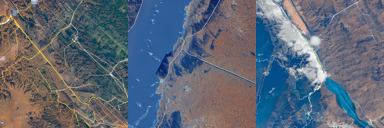

In [8]:
img_list = pipe(["Sentinel 2 satellite image of a highway"]*3, num_inference_steps=25).images
image_grid([x.resize((128,128)) for x in img_list], 1,3)

Next, we look at the images created after fine-tuning

In [9]:
pipe.unet.load_attn_procs("./trained_model/checkpoint-800")

In [ ]:
img_list = pipe(["Sentinel 2 satellite image of sks"]*3, num_inference_steps=25).images

 16%|█▌        | 4/25 [00:01<00:08,  2.61it/s]

In [ ]:
image_grid([x.resize((128,128)) for x in img_list], 1,3)

And eventually we look at the original images

In [ ]:
from PIL.ImageOps import exif_transpose
actual_img = [exif_transpose(Image.open("EuroSAT/Highway/Highway_{}.jpg".format(str(i)))) for i in range(1,4)]
image_grid([x.resize((128,128)) for x in actual_img], 1,3)

That's it! This finishes the notebook. In this notebook, we have seen how fine-tuning stable diffusion with custom images increases the quality of generated images. 

## Cleanup
After you close the notebook, please ensure that you close the instance as well using the icon (black square within white circle) on the left.